In [1]:
%pip install changeos

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install segment-geospatial groundingdino-py leafmap localtileserver opencv-python-headless

In [3]:
import os
os.chdir('/home/jovyan/EYODSC2024')

In [4]:
import azure.storage.blob


container_client = azure.storage.blob.ContainerClient(
    "https://eyodsc2024.blob.core.windows.net",
    container_name="training-data",
    credential='sp=racwdli&st=2024-02-17T18:57:34Z&se=2024-03-31T02:57:34Z&spr=https&sv=2022-11-02&sr=c&sig=%2BMxPLgtEZ2%2Fjiyox5WOxgtxNkoGjBrKKNxVzt5k3k8s%3D',
)


# ChangeOS

In [5]:
import changeos

# constructing ChangeOS model
# support 'changeos_r18', 'changeos_r34', 'changeos_r50', 'changeos_r101'
model = changeos.from_name('changeos_r101') # take 'changeos_r101' as example


In [6]:
import geopandas as gpd

# Read the building footprints shapefile
building_footprints = gpd.read_file('Buildings Footprint ROI/building_footprint_roi_challenge.shp')
building_footprints=building_footprints.drop(columns=['area_in_me'])

# Convert the coordinate reference system (CRS) to EPSG 32620 -> 32619
building_footprints = building_footprints.to_crs(epsg=32619)

# Calculate the area in square meters
building_footprints['area_in_sqm'] = building_footprints.geometry.area
# Filter
# Set 100m^2 threshold
print(building_footprints.shape)
building_footprints=building_footprints[building_footprints['area_in_sqm']>=100]
print(building_footprints.shape)
building_footprints=building_footprints[building_footprints['confidence']>=0.8]
print(building_footprints.shape)

(281572, 6)
(142378, 6)
(114197, 6)


## Process All

In [12]:
from concurrent.futures import ThreadPoolExecutor
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

import json
from shapely.geometry import Polygon, mapping
import numpy as np
import io
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import matplotlib.pyplot as plt
from shapely.affinity import scale, translate

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def bbox_to_polygon(bbox):
    minx, miny, maxx, maxy = bbox.left, bbox.bottom, bbox.right, bbox.top
    polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
    return polygon

new_width=1024
old_width=512

new_height=1024
old_height=512

pad_left = (new_width - old_width) // 2
pad_right = new_width - old_width - pad_left
pad_top = (new_height - old_height) // 2
pad_bottom = new_height - old_height - pad_top

start_x = (new_width - old_width) // 2
end_x = start_x + old_width
start_y = (new_height - old_height) // 2
end_y = start_y + old_height

def get_image(path):
    blob = container_client.get_blob_client(blob=path)
    file = io.BytesIO(blob.download_blob().readall())
    with rasterio.open(file) as src:
        raster = src.read()
        boundary=src.bounds
    
    img=reshape_as_image(raster)
    
    img_padded = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
    boundary = bbox_to_polygon(boundary)
    return img, img_padded, boundary

# Rasterize
def geom_to_raster(geometry, transform, out_shape):
    return rasterize([(mapping(geometry.boundary), 1)], out_shape=out_shape, fill=0, transform=transform, all_touched=True, dtype='uint8')

def tagging_pipeline(idx, visualise=False):
    info=dict()
    print(f"Tagging pipeline started for idx: {idx}")

    # Get pre-disaster image
    pre_img_path = f'Pre_Event_Grids_In_TIFF/Pre_Event_{idx:05}.tif'
    pre_img, pre_img_padded, pre_boundary = get_image(pre_img_path)

    # Get post-disaster image
    post_img_path = f'Post_Event_Grids_In_TIFF/Post_Event_{idx:05}.tif'
    post_img, post_img_padded, post_boundary = get_image(post_img_path)

    print(f"Tagging pipeline image downloaded for idx: {idx}")

    # Find building footprints
    building_footprints_intersects=building_footprints[building_footprints.intersects(pre_boundary)]
    if not building_footprints_intersects.empty:
        info['ey']=dict()
        info['ey']['num_of_building'] = building_footprints_intersects.shape[0]
        info['ey']['mean_building_sqm'] = building_footprints_intersects['area_in_sqm'].mean()
    
    print(f"Tagging pipeline building footprints extracted for idx: {idx}")

    # Prediction
    # model inference
    localisation, damage = model(pre_img_padded, post_img_padded)
    localisation=localisation[start_y:end_y, start_x:end_x]
    damage=damage[start_y:end_y, start_x:end_x]
    print(f"Tagging pipeline prediction extracted for idx: {idx}")

    info['changeos']=dict()
    info['changeos']['ratio_of_building'] = localisation.mean()

    if info['changeos']['ratio_of_building']>0:
        info['changeos']['damaged_building_vs_all_building'] = np.sum(damage>1)/localisation.sum()

    # Output
    # info['pre_img']=pre_img
    # info['post_img']=post_img
    info['boundary']=str(pre_boundary)
    print(info)

    # Define the file path
    file_path = os.path.join("Data Selection", f"{idx:05}.json")

    # Save the info dictionary as a JSON file
    with open(file_path, "w") as file:
        json.dump(info, file, indent=4, cls=NumpyEncoder)
    
    # Print complete message
    print(f"Tagging pipeline completed for idx: {idx}")

    if visualise:

        # Step 2: Clip the GeoDataFrame
        bbox = gpd.GeoDataFrame({'geometry': pre_boundary}, index=[0], crs=building_footprints_intersects.crs)
        clipped_gdf = gpd.clip(building_footprints_intersects, bbox)
        

        # Step 3: Rasterize the clipped GeoDataFrame
        # Define the transformation and raster size
        transform = rasterio.transform.from_bounds(*pre_boundary.bounds, width=512, height=512)
        out_shape = (512, 512)
        rasterized_image = np.zeros(out_shape, dtype='uint8')  # Initialize the raster array

        for geom in clipped_gdf.geometry:
            rasterized_image |= geom_to_raster(geom, transform, out_shape)

            
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))

        # Visualize pre_img
        axs[0, 0].imshow(pre_img)
        axs[0, 0].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[0, 0].set_title('Pre-Disaster Image')

        # Visualize post_img
        axs[0, 1].imshow(post_img)
        axs[0, 1].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[0, 1].set_title('Post-Disaster Image')
        axs[0, 1].axis('off')

        # Visualize localisation
        axs[1, 0].imshow(localisation, cmap='gray')
        axs[1, 0].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[1, 0].set_title('Localisation')
        axs[1, 0].axis('off')

        # Visualize damage
        axs[1, 1].imshow(damage, cmap='gray')
        axs[1, 1].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[1, 1].set_title('Damage')
        axs[1, 1].axis('off')


        # Adjust the layout
        plt.tight_layout()



Tagging pipeline started for idx: 4807
Tagging pipeline image downloaded for idx: 4807
Tagging pipeline building footprints extracted for idx: 4807
Tagging pipeline prediction extracted for idx: 4807
{'ey': {'num_of_building': 21, 'mean_building_sqm': 232.91980193089032}, 'changeos': {'ratio_of_building': 0.40311431884765625, 'damaged_building_vs_all_building': 0.757045252379961}, 'boundary': 'POLYGON ((807010.5000016 2035782.46911, 807010.5000016 2035938.71911, 807166.7500016 2035938.71911, 807166.7500016 2035782.46911, 807010.5000016 2035782.46911))'}
Tagging pipeline completed for idx: 4807


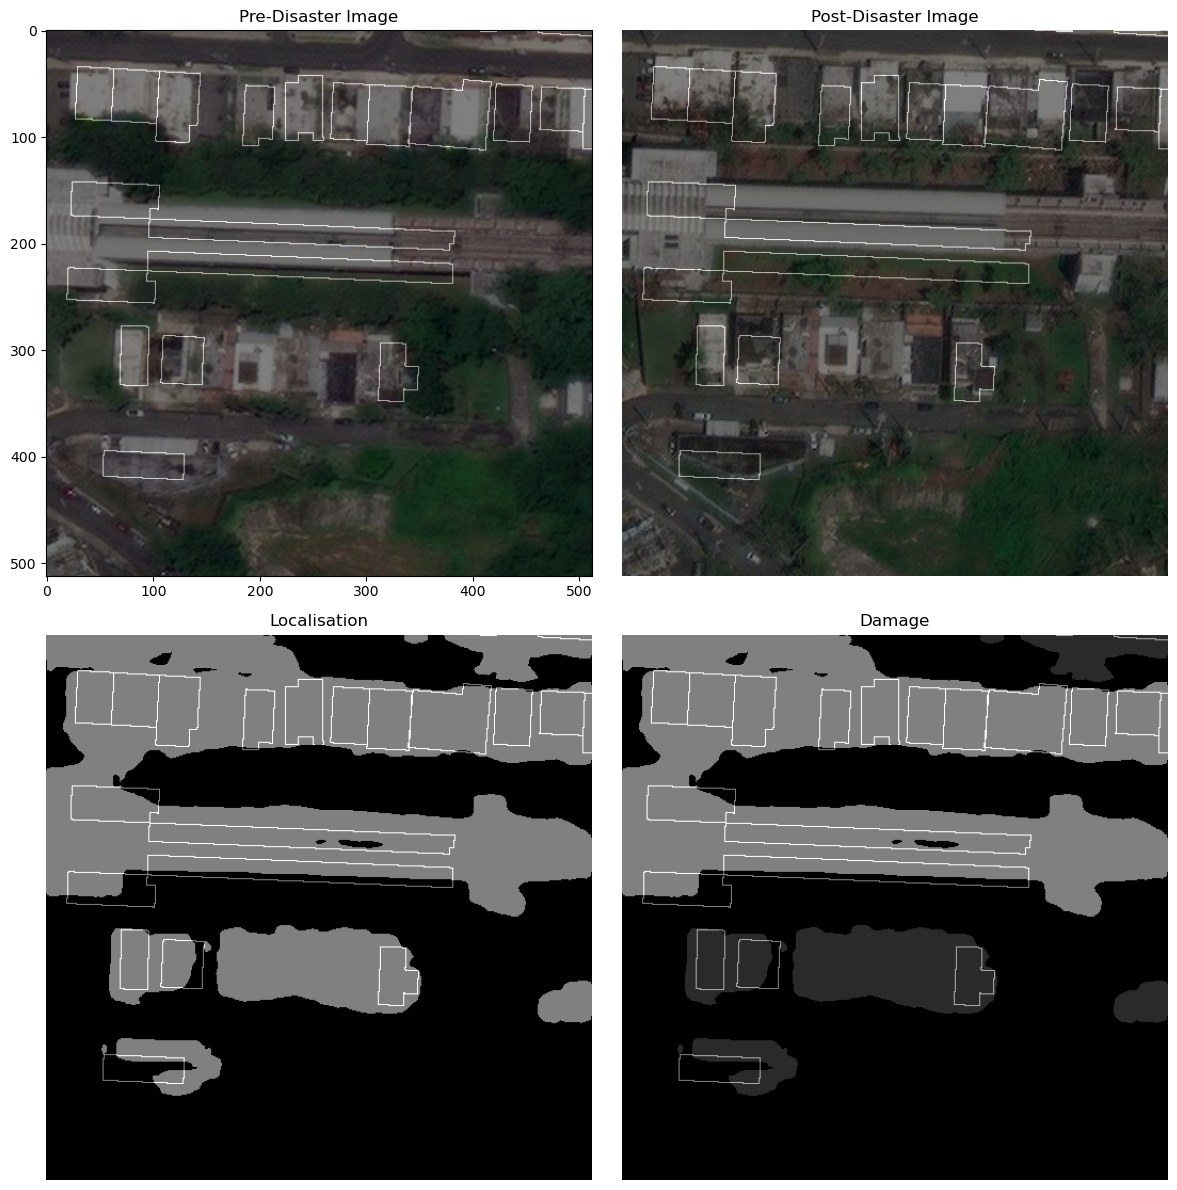

In [13]:
tagging_pipeline(4807,visualise=True)

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')            
# for id in range(10730):
#     tagging_pipeline(id)



Tagging pipeline started for idx: 0
Tagging pipeline image downloaded for idx: 0
Tagging pipeline building footprints extracted for idx: 0
Tagging pipeline prediction extracted for idx: 0
Tagging pipeline completed for idx: 0
Tagging pipeline started for idx: 1
Tagging pipeline image downloaded for idx: 1
Tagging pipeline building footprints extracted for idx: 1
Tagging pipeline prediction extracted for idx: 1
Tagging pipeline completed for idx: 1
Tagging pipeline started for idx: 2
Tagging pipeline image downloaded for idx: 2
Tagging pipeline building footprints extracted for idx: 2
Tagging pipeline prediction extracted for idx: 2
Tagging pipeline completed for idx: 2
Tagging pipeline started for idx: 3
Tagging pipeline image downloaded for idx: 3
Tagging pipeline building footprints extracted for idx: 3
Tagging pipeline prediction extracted for idx: 3
Tagging pipeline completed for idx: 3
Tagging pipeline started for idx: 4
Tagging pipeline image downloaded for idx: 4
Tagging pipelin

## Validation

In [ ]:
# from PIL import Image

# def get_image_validation(path):
#     img = Image.open(path)
#     img_padded = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
#     return img, img_padded


# def tagging_pipeline_validation(idx, visualise=False):
#     info=dict()
#     print(f"Tagging pipeline started for idx: {idx}")

#     # Get pre-disaster image
#     img_path = f'Submission data/Validation_Post_Event_{idx:03}.jpg'
#     img, img_padded = get_image_validation(img_path)

#     # Prediction
#     # model inference
#     localisation, damage = model(img_padded, img_padded)
#     localisation=localisation[start_y:end_y, start_x:end_x]
#     damage=damage[start_y:end_y, start_x:end_x]
#     print(f"Tagging pipeline prediction extracted for idx: {idx}")

#     info['ratio_of_building'] = localisation.mean()

#     if info['ratio_of_building']>0:
#         info['damaged_building_vs_all_building'] = np.sum(damage>1)/localisation.sum()


#     if visualise:
#         # Create a 1x2 subplot
#         fig, axs = plt.subplots(1, 2, figsize=(12, 12))

#         # Visualize img
#         axs[0].imshow(img)
#         axs[0].set_title('Validation Image')
#         axs[0].axis('off')

#         # Visualize localisation
#         axs[1].imshow(localisation, cmap='gray')
#         axs[1].set_title('Localisation')
#         axs[1].axis('off')

#         # Adjust the layout
#         plt.tight_layout()
#     return info


# validation=dict()
# for i in range(0,12):
#     idx=i+1
#     validation[idx]=tagging_pipeline_validation(idx,visualise=False)

# import pandas as pd
# validation_df=pd.DataFrame.from_dict(validation, orient='index')
# validation_df

## Select
0.1 - 0.5

In [9]:
import pandas as pd
import glob
import json

# Path to the folder containing JSON files
folder_path = 'Data Selection/*.json'  # Update this path

# Create an empty DataFrame
df = pd.DataFrame()

# Iterate over all JSON files in the folder
for file_name in glob.glob(folder_path):
    # Read the current JSON file
    with open(file_name) as f:
        json_data = json.load(f)

    json_data['index'] = int(file_name.split('/')[-1].split('.')[0].split('_')[-1])
    
    # Depending on the structure of your JSON, you might need to process or normalize it before appending
    # For example, if json_data is a dictionary that fits directly as a DataFrame row
    temp_df = pd.DataFrame([json_data])
    
    # Append to the main DataFrame
    df = pd.concat([df, temp_df], ignore_index=True)
    print(file_name)

# Now, df contains all JSON files as rows
df

# Flatten 'col1' and 'col2', and merge back to the original dataframe
for col in ['ey', 'changeos']:
    flattened_col_df = pd.json_normalize(df[col])
    flattened_col_df.columns = [f"{col}_{subcol}" for subcol in flattened_col_df.columns]  # Prefix the column names to avoid collisions
    df = df.drop(columns=[col]).join(flattened_col_df)  # Drop the original dict columns and join with the flattened columns

# df now has the flattened columns from 'col1' and 'col2'
df

Data Selection/04807.json
Data Selection/06476.json
Data Selection/01755.json
Data Selection/04386.json
Data Selection/02945.json
Data Selection/04364.json
Data Selection/06066.json
Data Selection/04590.json
Data Selection/10038.json
Data Selection/10290.json
Data Selection/02594.json
Data Selection/08947.json
Data Selection/02304.json
Data Selection/03831.json
Data Selection/03767.json
Data Selection/08613.json
Data Selection/00159.json
Data Selection/08083.json
Data Selection/00052.json
Data Selection/07771.json
Data Selection/06621.json
Data Selection/03159.json
Data Selection/05281.json
Data Selection/09827.json
Data Selection/01073.json
Data Selection/08466.json
Data Selection/05655.json
Data Selection/08129.json
Data Selection/08198.json
Data Selection/04273.json
Data Selection/07206.json
Data Selection/08255.json
Data Selection/08820.json
Data Selection/07841.json
Data Selection/05139.json
Data Selection/02416.json
Data Selection/10159.json
Data Selection/00458.json
Data Selecti

boundary  index  \
0      POLYGON ((807010.5000016 2035782.46911, 807010...   4807   
1      POLYGON ((805916.7500016 2030157.46911, 805916...   6476   
2      POLYGON ((803260.5000016 2034532.46911, 803260...   1755   
3      POLYGON ((801698.0000016 2033907.46911, 801698...   4386   
4      POLYGON ((796854.2500016 2033438.71911, 796854...   2945   
...                                                  ...    ...   
10725  POLYGON ((800291.7500016 2031719.96911, 800291...   8268   
10726  POLYGON ((798260.5000016 2040626.21911, 798260...   5324   
10727  POLYGON ((807791.7500016 2040782.46911, 807791...   7472   
10728  POLYGON ((798885.5000016 2041407.46911, 798885...   3980   
10729  POLYGON ((802479.2500016 2031563.71911, 802479...   4720   

       ey_num_of_building  ey_mean_building_sqm  changeos_ratio_of_building  \
0                    21.0            232.919802                    0.403114   
1                    19.0            156.229979                    0.211330   
2                    13.0            423.491624                    0.087769   
3                    11.0            631.092208                    0.245975   
4                    22.0            274.024917                    0.183697   
...                   ...                   ...                         ...   
10725                30.0            206.412881                    0.245743   
10726                54.0            181.946819                    0.665771   
10727                 5.0            766.321460                    0.000004   
10728                29.0            267.956800                    0.351730   
10729                 5.0            179.790275                    0.089390   

       changeos_damaged_building_vs_all_building  
0                                       0.757045  
1                                       0.599686  
2                                       0.000000  
3                                       0.506444  
4                                       0.000000  
...                                          ...  
10725                                   0.153632  
10726                                   0.000000  
10727                                   0.000000  
10728                                   0.000000  
10729                                   0.000000  

[10730 rows x 6 columns]

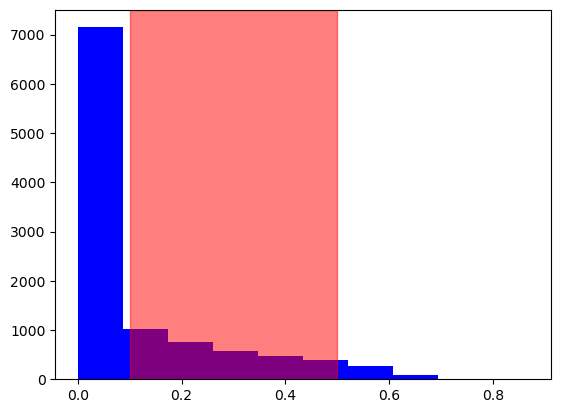

The percentage of values between 0.1 and 0.5 is: 27.129543336439887%
The number of values between 0.1 and 0.5 is: 2911


boundary  index  \
8892  POLYGON ((806698.0000016 2031876.21911, 806698...    160   
5551  POLYGON ((798573.0000016 2040938.71911, 798573...   1404   
8009  POLYGON ((807479.2500016 2031407.46911, 807479...   8926   
7597  POLYGON ((802948.0000016 2041094.96911, 802948...   5944   
5673  POLYGON ((799354.2500016 2039063.71911, 799354...   2753   

      ey_num_of_building  ey_mean_building_sqm  changeos_ratio_of_building  \
8892                23.0            171.051085                    0.232635   
5551                14.0            429.852510                    0.228676   
8009                12.0            356.276854                    0.114658   
7597                34.0            149.701345                    0.172123   
5673                23.0            180.118528                    0.203480   

      changeos_damaged_building_vs_all_building  
8892                                   0.000000  
5551                                   0.000000  
8009                                   0.053731  
7597                                   0.000000  
5673                                   0.000000

In [19]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(df['changeos_ratio_of_building'], color='blue')

# Color the bars between 0.1 and 0.5 in red
plt.axvspan(0.1, 0.5, color='red', alpha=0.5)

# Display the plot
plt.show()

# Calculate the percentage
percentage = (df['changeos_ratio_of_building'].between(0.1, 0.5).sum() / len(df['changeos_ratio_of_building'])) * 100

# Print the percentage
print(f"The percentage of values between 0.1 and 0.5 is: {percentage}%")
print(f"The number of values between 0.1 and 0.5 is: {df['changeos_ratio_of_building'].between(0.1, 0.5).sum()}")
selected_df=df[df['changeos_ratio_of_building'].between(0.1, 0.5)]
selected_df.sample(n=5)

In [20]:
selected_df.to_csv('./selected_df_info.csv',index=False)

Tagging pipeline started for idx: 1134
Tagging pipeline image downloaded for idx: 1134
Tagging pipeline building footprints extracted for idx: 1134
Tagging pipeline prediction extracted for idx: 1134
{'ey': {'num_of_building': 24, 'mean_building_sqm': 325.16539584348294}, 'changeos': {'ratio_of_building': 0.195831298828125, 'damaged_building_vs_all_building': 0.0}, 'boundary': 'POLYGON ((804510.5000016 2036563.71911, 804510.5000016 2036719.96911, 804666.7500016 2036719.96911, 804666.7500016 2036563.71911, 804510.5000016 2036563.71911))'}
Tagging pipeline completed for idx: 1134


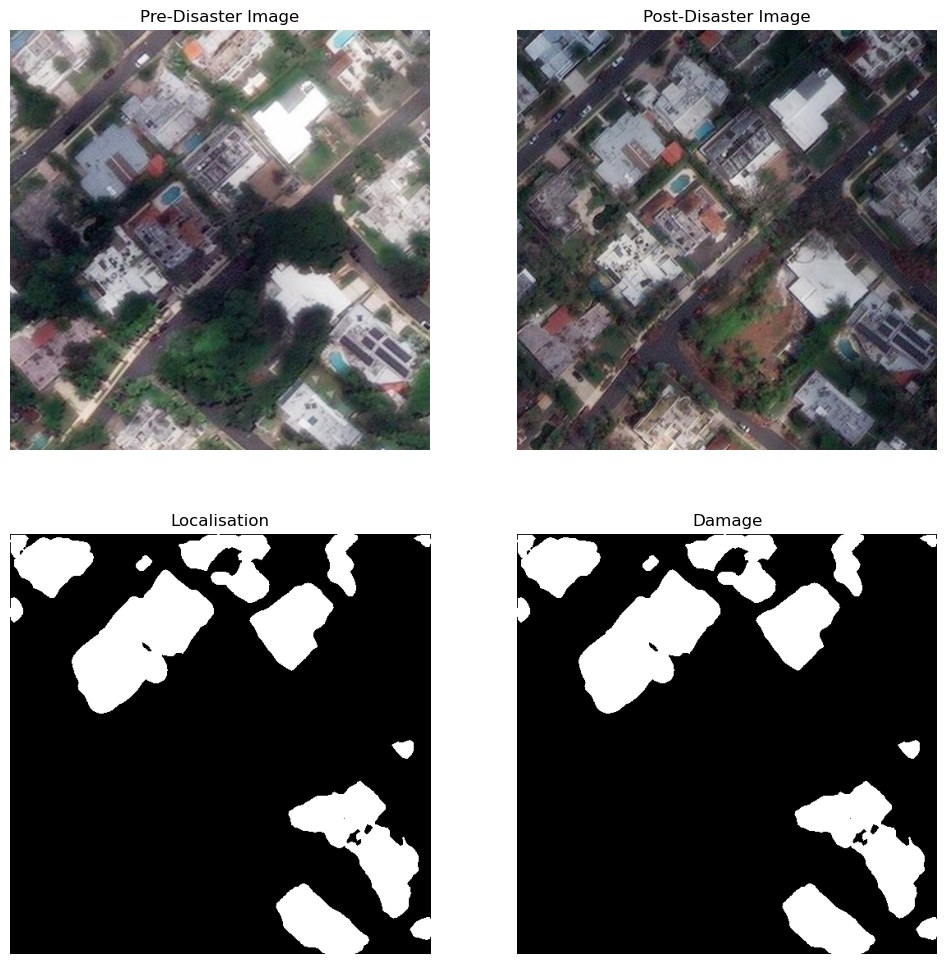

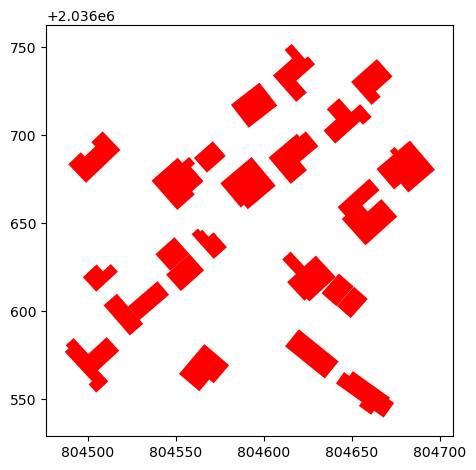

In [16]:
tagging_pipeline(1134, visualise=True)

256 256 256 256
Pre-disaster data shape: (1024, 1024, 3)
Post-disaster data shape: (1024, 1024, 3)


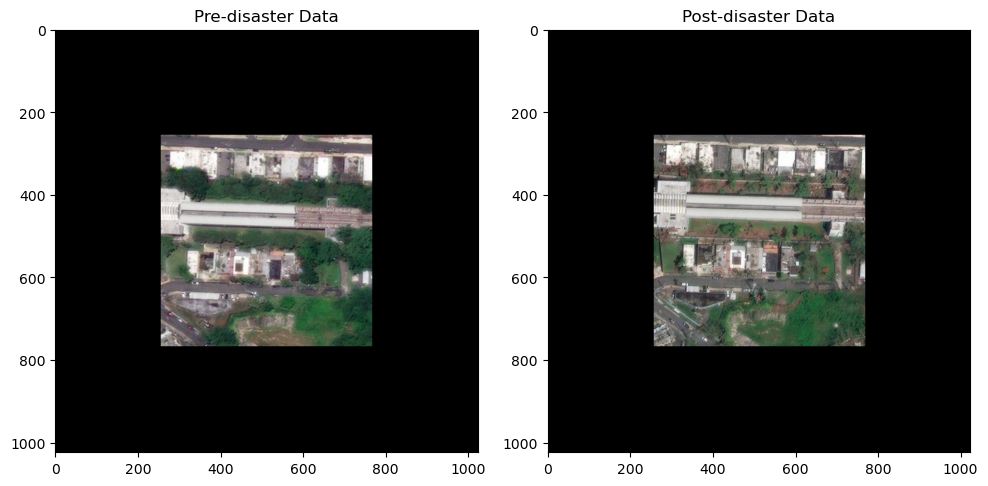

In [11]:
# 512->1024
# 1024*1024
from PIL import Image
import io
import numpy as np

pre_disaster_path='Pre_Event_Grids_In_TIFF/Pre_Event_04807.tif'
post_disaster_path='Post_Event_Grids_In_TIFF/Post_Event_04807.tif'

pre_disaster_blob = container_client.get_blob_client(blob=pre_disaster_path)
post_disaster_blob = container_client.get_blob_client(blob=post_disaster_path)

# Read the image data into BytesIO objects
pre_disaster_image = io.BytesIO(pre_disaster_blob.download_blob().readall())
post_disaster_image = io.BytesIO(post_disaster_blob.download_blob().readall())

# Convert image to data
pre_disaster_data = np.array(Image.open(pre_disaster_image))
post_disaster_data = np.array(Image.open(post_disaster_image))

# Define new width and height
new_width = 1024
new_height = 1024

# Reshape the data to match the expected input shape of the model
pre_disaster_data = pre_disaster_data.reshape(pre_disaster_data.shape[0], pre_disaster_data.shape[1], 3)
post_disaster_data = post_disaster_data.reshape(post_disaster_data.shape[0], post_disaster_data.shape[1], 3)


# Calculate padding sizes
pad_left = (new_width - pre_disaster_data.shape[1]) // 2
pad_right = new_width - pre_disaster_data.shape[1] - pad_left
pad_top = (new_height - pre_disaster_data.shape[0]) // 2
pad_bottom = new_height - pre_disaster_data.shape[0] - pad_top

print(pad_left,pad_right,pad_top,pad_bottom)
# Add padding to the images
pre_disaster_data = np.pad(pre_disaster_data, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
post_disaster_data = np.pad(post_disaster_data, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)


# Print the shape of the data
print("Pre-disaster data shape:", pre_disaster_data.shape)
print("Post-disaster data shape:", post_disaster_data.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(pre_disaster_data)
plt.title('Pre-disaster Data')

plt.subplot(122)
plt.imshow(post_disaster_data)
plt.title('Post-disaster Data')


plt.tight_layout()
plt.show()

## Download All Files Back

In [9]:
selected_df=pd.read_csv('selected_df_info.csv')
selected_df

def download_image(path, name):
    
    blob_client = container_client.get_blob_client(blob=path)
    with open(file=os.path.join('Training data', name), mode="wb") as sample_blob:
        download_stream = blob_client.download_blob()
        sample_blob.write(download_stream.readall())

    return


for i in selected_df['index']:
    pre_img_name=f'Pre_Event_{i:05}.jpg'
    pre_img_path=f'Pre_Event_Grids_In_JPEG/{pre_img_name}'
    download_image(pre_img_path,pre_img_name)

    post_img_name=f'Post_Event_{i:05}.jpg'
    post_img_path=f'Post_Event_Grids_In_JPEG/{post_img_name}'
    download_image(post_img_path,post_img_name)
    break


    

# SAM

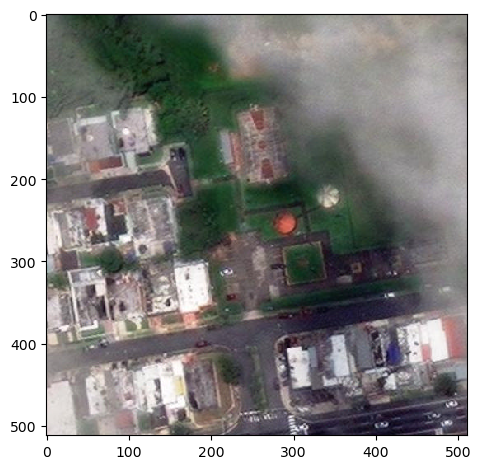

In [19]:
# pre_disaster_path='Pre_Event_Grids_In_TIFF/Pre_Event_00204.tif'
# pre_disaster_blob = container_client.get_blob_client(blob=pre_disaster_path)
# pre_disaster_url = pre_disaster_blob.url
# pre_disaster_url

# import skimage as ski
# img = ski.io.imread(pre_disaster_url, plugin='pil')
# ski.io.imshow(img)

In [26]:
# from samgeo.text_sam import LangSAM

# sam = LangSAM()
# text_prompt='roof'

final text_encoder_type: bert-base-uncased


Pre_Event_00204.tif?sp=racwdli&st=2024-02-17T18%3A57%3A34Z&se=2024-03-31T02%3A57%3A34Z&spr=https&sv=2022-11-02&sr=c&sig=%2BMxPLgtEZ2%2Fjiyox5WOxgtxNkoGjBrKKNxVzt5k3k8s%3D already exists. Skip downloading. Set overwrite=True to overwrite.


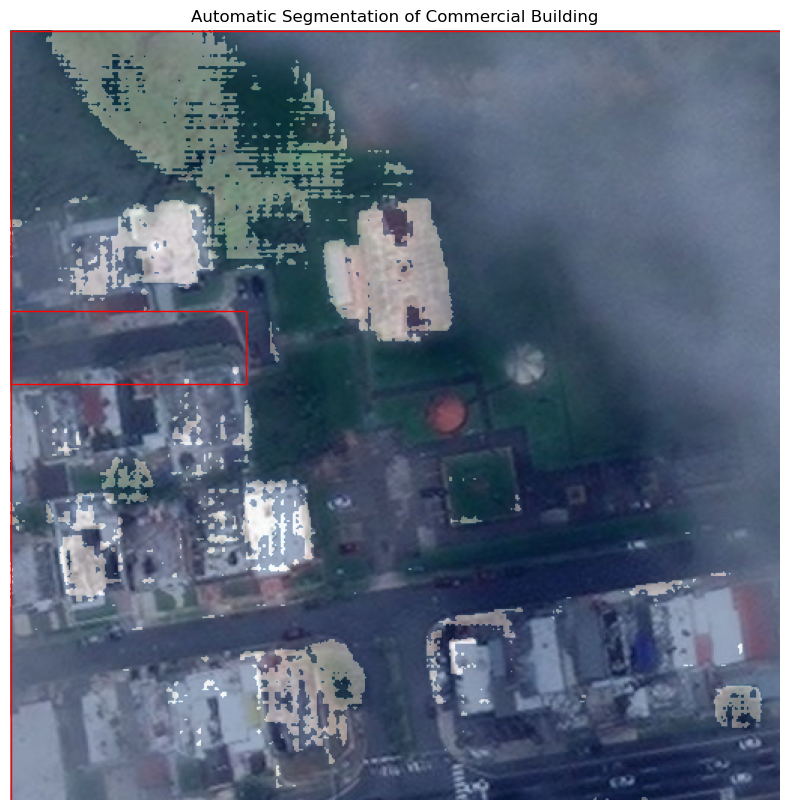

In [27]:
# sam.predict(pre_disaster_url, text_prompt, box_threshold=0.24, text_threshold=0.24)
# sam.show_anns(
#     cmap='Blues',
#     box_color='red',
#     title='Automatic Segmentation of Commercial Building',
#     blend=True,
# )

Array Similarity

- Ratio
- Similarity


Image Histogram

NMS

IOU